# Importation des bibliotheques

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D ,BatchNormalization
from keras.optimizers import Adam , RMSprop , SGD
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from google.colab import drive 
import pandas as pd
%matplotlib inline
tf.__version__

'2.4.0'

Connexion au Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#le chemin du dossier 'data' qui contient deux dossiers , 'train' et 'test'
data_path='/content/drive/MyDrive/datasetskin/data'

In [ ]:
train_dir = os.path.join(data_path, "train")
test_dir = os.path.join(data_path, "test")

In [ ]:
# utile pour obtenir le nombre de classes
folders = glob(train_dir+'/*')

# Augmentation

ImageDataGenerator() est une technique d’application de différentes transformations aux images originales qui se traduit par de multiples copies transformées de la même image. Chaque copie, cependant, est différente de l’autre dans certains aspects en fonction des techniques d’augmentation que vous appliquez comme le déplacement, la rotation, le retournement, etc.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
#on a fixé le batch_size à 64 pour les images d'entrenement et du test.
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
#Tailles des images
IMG_SHAPE = (224, 224,3)

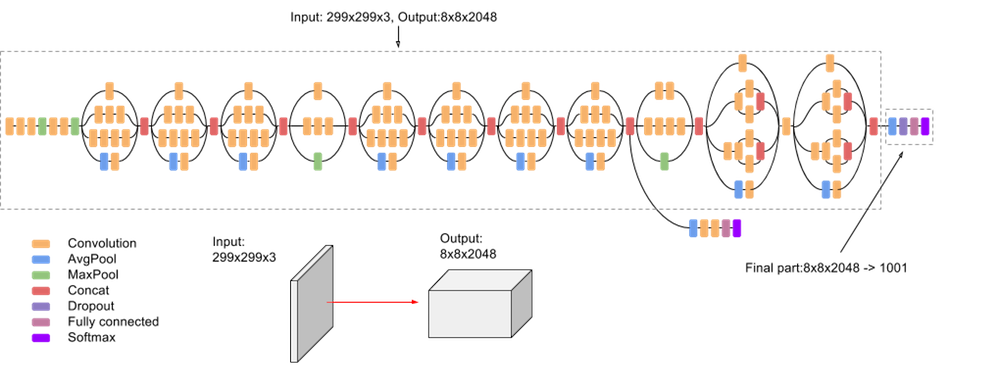

est une architecture de réseau neuronal convolutionnelle de la famille Inception qui apporte plusieurs améliorations, y compris l’utilisation du lissage des étiquettes, des convolutions factorisées 7 x 7 et l’utilisation d’un classeur auxiliaire pour propager l’information sur les étiquettes plus bas dans le réseau (avec l’utilisation de la normalisation par lots pour les couches dans la face latérale).

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
base_model_v3 = InceptionV3(include_top=False,
                   input_shape=IMG_SHAPE,
                   weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


# Frezing

In [ ]:
#Freeze
base_model_v3.trainable = False

In [ ]:
x1 = Flatten()(base_model_v3.output)
x1 = Dense(128, activation='relu')(x1)
#x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = BatchNormalization()(x1)
x1 = Dense(len(folders), activation='sigmoid')(x1)

In [ ]:
model_v3 = Model(inputs=base_model_v3.input, outputs=x1)

# Compilation

In [ ]:
model_v3.compile(  loss='binary_crossentropy',
  optimizer= RMSprop(lr=0.0001),
  metrics=['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Entrainement

In [ ]:
history=model_v3.fit(training_set, epochs=50, validation_data=test_set, callbacks=[learning_rate_reduction])

Epoch 1/50
83/83 [==============================] - 714s 9s/step - loss: 0.6457 - accuracy: 0.6839 - val_loss: 0.4357 - val_accuracy: 0.8015
Epoch 2/50
83/83 [==============================] - 35s 425ms/step - loss: 0.4796 - accuracy: 0.7892 - val_loss: 0.4199 - val_accuracy: 0.8076
Epoch 3/50
83/83 [==============================] - 35s 427ms/step - loss: 0.4592 - accuracy: 0.7942 - val_loss: 0.4069 - val_accuracy: 0.8273
Epoch 4/50
83/83 [==============================] - 35s 422ms/step - loss: 0.4290 - accuracy: 0.8081 - val_loss: 0.3968 - val_accuracy: 0.8288
Epoch 5/50
83/83 [==============================] - 35s 424ms/step - loss: 0.4506 - accuracy: 0.8086 - val_loss: 0.3862 - val_accuracy: 0.8364
Epoch 6/50
83/83 [==============================] - 35s 423ms/step - loss: 0.4082 - accuracy: 0.8281 - val_loss: 0.3756 - val_accuracy: 0.8303
Epoch 7/50
83/83 [==============================] - 35s 425ms/step - loss: 0.3939 - accuracy: 0.8352 - val_loss: 0.3676 - val_accuracy: 0.8348
E

# Plot

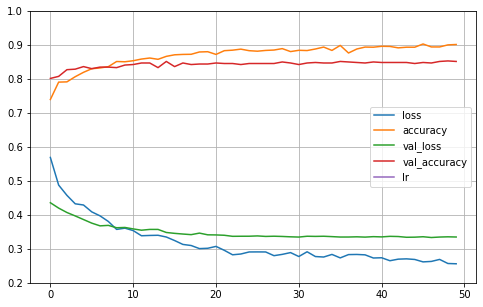

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.2, 1)
plt.show()

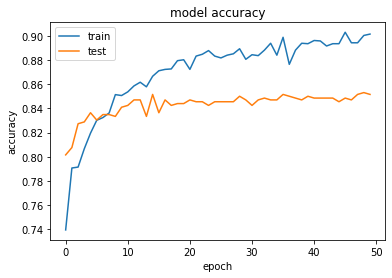

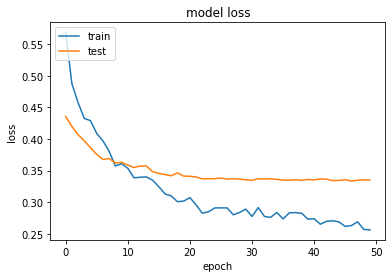

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Fine_tuning

In [ ]:
#unfreeze the model
base_model_v3.trainable = True

In [ ]:
#compilation du model en utilisant optimiseur SGD 
model_v3.compile(  loss='binary_crossentropy',
  optimizer= SGD(lr=0.00001,momentum=0.9),
  metrics=['accuracy'])

#je dois ajouterr
fine_tuning_v3 = model_v3.fit(training_set, epochs=38, validation_data=test_set,callbacks=[learning_rate_reduction])

Epoch 1/38
83/83 [==============================] - 48s 499ms/step - loss: 0.6362 - accuracy: 0.6920 - val_loss: 0.4883 - val_accuracy: 0.7848
Epoch 2/38
83/83 [==============================] - 40s 483ms/step - loss: 0.5712 - accuracy: 0.7441 - val_loss: 0.5277 - val_accuracy: 0.7500
Epoch 3/38
83/83 [==============================] - 40s 483ms/step - loss: 0.5784 - accuracy: 0.7503 - val_loss: 0.5264 - val_accuracy: 0.7742
Epoch 4/38
83/83 [==============================] - 40s 481ms/step - loss: 0.5357 - accuracy: 0.7601 - val_loss: 0.5175 - val_accuracy: 0.7833
Epoch 5/38
83/83 [==============================] - 40s 483ms/step - loss: 0.5055 - accuracy: 0.7828 - val_loss: 0.5086 - val_accuracy: 0.7803
Epoch 6/38
83/83 [==============================] - 40s 479ms/step - loss: 0.5736 - accuracy: 0.7424 - val_loss: 0.5064 - val_accuracy: 0.7864
Epoch 7/38
83/83 [==============================] - 40s 481ms/step - loss: 0.4968 - accuracy: 0.7911 - val_loss: 0.4965 - val_accuracy: 0.7909

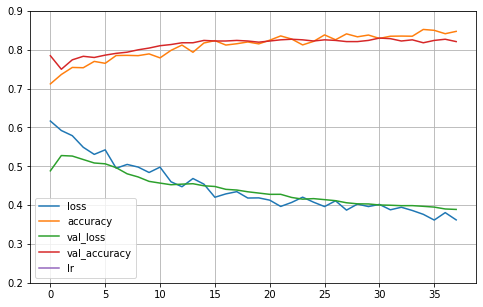

In [ ]:
pd.DataFrame(fine_tuning_v3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.2, 0.9)
plt.show()

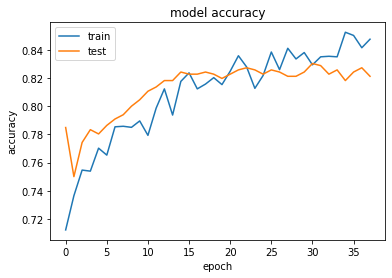

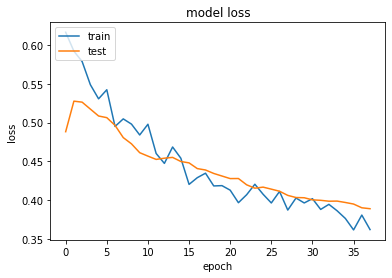

In [ ]:
# summarize history for accuracy
plt.plot(fine_tuning_v3.history['accuracy'])
plt.plot(fine_tuning_v3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fine_tuning_v3.history['loss'])
plt.plot(fine_tuning_v3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()